## Generating expert trajectories

### Environment Setup - Predator-Prey

Custom 2-agent grid world using Gymnasium.

*Features*:

Grid size: 3x3

A1 starts at (0,0), A2 starts at (0,2).

Goals: A1 reach goal at (2,2), A2 catch A1

Actions: [UP, DOWN, LEFT, RIGHT] (4 actions per agent).

Observations: Positions of both agents.

Rewards:
- if A1 reaches goal, +10 for A1 -10 for A2
- if A2 catches A1, +10 for A2 -10 for A1

Agents moving simultaneously, game ends as soon as A1 reaches the goal OR A2 catches A1

In [17]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

grid_size = 3
max_steps = 100

class GridGame1(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 4}

    def __init__(self):
        self.grid_size = grid_size
        self.max_steps = max_steps

        self.init_positions = [(0, 0), (0, 2)]  # A1 at (0,0), A2 at (0,2)
        self.goal_pos_a1 = (2, 2)  # A1's goal
        self.reset()

        self.action_space = spaces.MultiDiscrete([4, 4])
        self.observation_space = spaces.Dict({
            "agent1": spaces.Box(0, self.grid_size - 1, shape=(2,), dtype=int),
            "agent2": spaces.Box(0, self.grid_size - 1, shape=(2,), dtype=int)
        })

    def reset(self):
        self.agent1_pos, self.agent2_pos = self.init_positions
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return {
            "agent1": np.array(self.agent1_pos),
            "agent2": np.array(self.agent2_pos)
        }

    def step(self, actions):
        self.steps += 1
    
        # Move agents
        new_pos1 = self._move(self.agent1_pos, actions[0])
        new_pos2 = self._move(self.agent2_pos, actions[1])
    
        self.agent1_pos = new_pos1
        self.agent2_pos = new_pos2
    
        done = False
        reward1 = 0
        reward2 = 0
    
        if self.agent1_pos == self.agent2_pos:
            # A2 catches A1 — including the goal cell
            reward1 = -10
            reward2 = 10
            done = True
    
        elif self.agent1_pos == self.goal_pos_a1:
            # A1 reaches goal safely (not a catch)
            reward1 = 10
            reward2 = -10
            done = True
    
        done = done or self.steps >= self.max_steps
    
        return self._get_obs(), (reward1, reward2), done, {}, {}


    def _move(self, pos, action):
        x, y = pos
        if action == 0:  # UP
            x = max(0, x - 1)
        elif action == 1:  # DOWN
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # LEFT
            y = max(0, y - 1)
        elif action == 3:  # RIGHT
            y = min(self.grid_size - 1, y + 1)
        return (x, y)

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), '·', dtype='<U5')

        # Mark goal for A1
        gx, gy = self.goal_pos_a1
        grid[gx, gy] = 'G1'

        # Mark agents
        a1x, a1y = self.agent1_pos
        a2x, a2y = self.agent2_pos

        if self.agent1_pos == self.agent2_pos:
            grid[a1x, a1y] = 'A*'
        else:
            grid[a1x, a1y] = 'A1'
            grid[a2x, a2y] = 'A2'

        print("Current State:")
        for row in grid:
            print(" ".join(f"{cell:^5}" for cell in row))
        print()


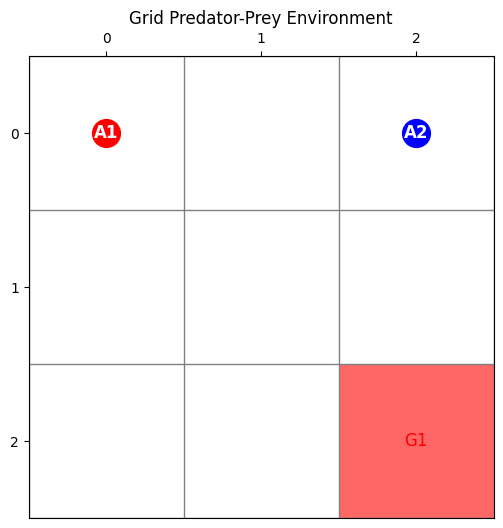

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_env_state(env):
    fig, ax = plt.subplots(figsize=(6, 6))

    # 1) Draw grid lines
    for x in range(env.grid_size + 1):
        ax.axvline(x, color='gray', linestyle='-', linewidth=1)
    for y in range(env.grid_size + 1):
        ax.axhline(y, color='gray', linestyle='-', linewidth=1)

    # 2) Set axis limits and ticks
    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_xticks([i + 0.5 for i in range(env.grid_size)])
    ax.set_yticks([i + 0.5 for i in range(env.grid_size)])
    ax.set_xticklabels([str(i) for i in range(env.grid_size)])
    ax.set_yticklabels([str(i) for i in range(env.grid_size)])

    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.invert_yaxis()
    ax.set_title("Grid Predator-Prey Environment")

    # Helpers
    def cell_coords(row, col):
        return (col, row)

    def center_coords(row, col):
        return (col + 0.5, row + 0.5)

    # 3) Highlight A1’s goal at (2, 2)
    gx, gy = env.goal_pos_a1
    ax.add_patch(patches.Rectangle(cell_coords(gx, gy), 1, 1, facecolor='red', alpha=0.6))
    ax.text(*center_coords(gx, gy), "G1", ha='center', va='center', fontsize=12, color='red')

    # 4) Plot agents
    a1_row, a1_col = env.agent1_pos
    a2_row, a2_col = env.agent2_pos

    if (a1_row, a1_col) == (a2_row, a2_col):
        ax.plot(*center_coords(a1_row, a1_col), 'purple', marker='o', markersize=20)
        ax.text(*center_coords(a1_row, a1_col), "A1&A2", fontsize=10, ha='center', va='center', color='white', fontweight='bold')
    else:
        ax.plot(*center_coords(a1_row, a1_col), 'ro', markersize=20)
        ax.text(*center_coords(a1_row, a1_col), "A1", fontsize=12, ha='center', va='center', color='white', fontweight='bold')

        ax.plot(*center_coords(a2_row, a2_col), 'bo', markersize=20)
        ax.text(*center_coords(a2_row, a2_col), "A2", fontsize=12, ha='center', va='center', color='white', fontweight='bold')

    plt.show()


env = GridGame1()
env.reset()
plot_env_state(env)


### Nash Q-Learning

In [19]:
import numpy as np
from nashpy import Game
import matplotlib.pyplot as plt

class NashQLearner:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.5, min_epsilon=0.01, decay_rate=0.0005):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.epsilon_history = []

        self.grid_size = env.grid_size
        # Q1 and Q2: [a1_x, a1_y, a2_x, a2_y, a1_action, a2_action]
        self.Q1 = np.zeros((self.grid_size, self.grid_size, self.grid_size, self.grid_size, 4, 4))
        self.Q2 = np.zeros((self.grid_size, self.grid_size, self.grid_size, self.grid_size, 4, 4))

    def decay_epsilon(self, episode):
        self.epsilon = max(self.min_epsilon, self.epsilon * 0.999)
        self.epsilon_history.append(self.epsilon)

    def get_action(self, state, explore=True):
        s = self._state_to_index(state)

        game = Game(self.Q1[s], self.Q2[s])
        equilibria = list(game.support_enumeration())

        if not equilibria or (explore and np.random.rand() < self.epsilon):
            return np.random.randint(0, 4), np.random.randint(0, 4)

        pi1, pi2 = equilibria[np.random.randint(len(equilibria))]  # Pick first Nash
        a1 = np.random.choice(4, p=pi1)
        a2 = np.random.choice(4, p=pi2)
        return a1, a2

    def update(self, state, actions, rewards, next_state):
        s = self._state_to_index(state)
        s_next = self._state_to_index(next_state)
        a1, a2 = actions
        r1, r2 = rewards

        game_next = Game(self.Q1[s_next], self.Q2[s_next])
        equilibria_next = list(game_next.support_enumeration())

        if not equilibria_next:
            nash_q1 = 0
            nash_q2 = 0
        else:
            pi1_next, pi2_next = equilibria_next[0]

            # Compute entropy bonus
            entropy1 = -np.sum(pi1_next * np.log(pi1_next + 1e-8))
            entropy2 = -np.sum(pi2_next * np.log(pi2_next + 1e-8))

            # Add entropy to Q-values
            nash_q1 = np.sum(np.outer(pi1_next, pi2_next) * self.Q1[s_next]) + 0.05 * entropy1
            nash_q2 = np.sum(np.outer(pi1_next, pi2_next) * self.Q2[s_next]) + 0.05 * entropy2

        # Q-learning update
        self.Q1[s][a1][a2] += self.alpha * (r1 + self.gamma * nash_q1 - self.Q1[s][a1][a2])
        self.Q2[s][a1][a2] += self.alpha * (r2 + self.gamma * nash_q2 - self.Q2[s][a1][a2])

    def _state_to_index(self, state):
        """Convert observation dict to discrete Q-table index."""
        return (
            state["agent1"][0], state["agent1"][1],
            state["agent2"][0], state["agent2"][1]
        )

    def plot_learning_curve(self, episode_rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(len(episode_rewards)), [r[0] for r in episode_rewards], label="Agent 1 (Prey)")
        plt.plot(np.arange(len(episode_rewards)), [r[1] for r in episode_rewards], label="Agent 2 (Predator)")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Learning Curve - Predator-Prey")
        plt.legend()
        plt.grid(True)
        plt.show()


##### Training Loop

c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (16) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (14) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Episode 000 | Avg Reward - Prey (A1): -10.00 | Predator (A2): 10.00


c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (12) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (10) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (8) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration

Episode 010 | Avg Reward - Prey (A1): -10.00 | Predator (A2): 10.00
Episode 020 | Avg Reward - Prey (A1): -8.00 | Predator (A2): 8.00
Episode 030 | Avg Reward - Prey (A1): -4.00 | Predator (A2): 4.00
Episode 040 | Avg Reward - Prey (A1): -8.00 | Predator (A2): 8.00
Episode 050 | Avg Reward - Prey (A1): 0.00 | Predator (A2): 0.00


c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (0) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Episode 060 | Avg Reward - Prey (A1): -4.00 | Predator (A2): 4.00
Episode 070 | Avg Reward - Prey (A1): -4.00 | Predator (A2): 4.00
Episode 080 | Avg Reward - Prey (A1): -8.00 | Predator (A2): 8.00
Episode 090 | Avg Reward - Prey (A1): -4.00 | Predator (A2): 4.00
Episode 100 | Avg Reward - Prey (A1): -8.00 | Predator (A2): 8.00
Episode 110 | Avg Reward - Prey (A1): 0.00 | Predator (A2): 0.00
Episode 120 | Avg Reward - Prey (A1): -8.00 | Predator (A2): 8.00


c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (20) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Episode 130 | Avg Reward - Prey (A1): -4.00 | Predator (A2): 4.00
Episode 140 | Avg Reward - Prey (A1): -2.00 | Predator (A2): 2.00
Episode 150 | Avg Reward - Prey (A1): 0.00 | Predator (A2): 0.00
Episode 160 | Avg Reward - Prey (A1): 0.00 | Predator (A2): 0.00
Episode 170 | Avg Reward - Prey (A1): -4.00 | Predator (A2): 4.00
Episode 180 | Avg Reward - Prey (A1): -4.00 | Predator (A2): 4.00
Episode 190 | Avg Reward - Prey (A1): -4.00 | Predator (A2): 4.00
Episode 200 | Avg Reward - Prey (A1): -5.00 | Predator (A2): 5.00
Episode 210 | Avg Reward - Prey (A1): -2.00 | Predator (A2): 2.00
Episode 220 | Avg Reward - Prey (A1): -6.00 | Predator (A2): 6.00
Episode 230 | Avg Reward - Prey (A1): -2.00 | Predator (A2): 2.00
Episode 240 | Avg Reward - Prey (A1): -2.00 | Predator (A2): 2.00
Episode 250 | Avg Reward - Prey (A1): -6.00 | Predator (A2): 6.00
Episode 260 | Avg Reward - Prey (A1): -3.00 | Predator (A2): 3.00
Episode 270 | Avg Reward - Prey (A1): -8.00 | Predator (A2): 8.00
Episode 280 

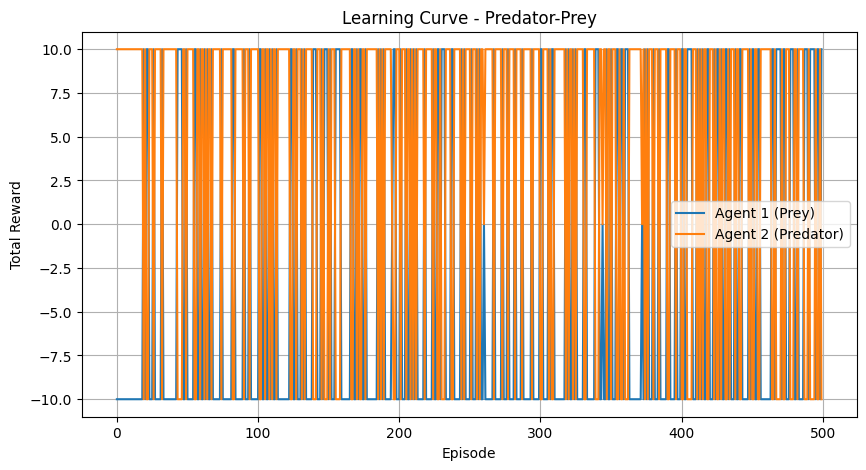

In [ ]:
env = GridGame1()
agent = NashQLearner(env, alpha=0.05, gamma=0.99, epsilon=0.5)

all_episode_rewards = []
epsilon_decay = []
n_episodes = 500

for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    total_reward = [0, 0]  # [A1 (Prey), A2 (Predator)]

    while not done:
        actions = agent.get_action(state)
        next_state, rewards, terminated, truncated, _ = env.step(actions)
        done = terminated or truncated

        agent.update(state, actions, rewards, next_state)
        state = next_state

        total_reward[0] += rewards[0]
        total_reward[1] += rewards[1]

    all_episode_rewards.append(total_reward)
    agent.decay_epsilon(episode)
    epsilon_decay.append(agent.epsilon)

    if episode % 10 == 0:
        avg_rewards = np.mean(all_episode_rewards[-10:], axis=0)
        print(f"Episode {episode:03d} | Avg Reward - Prey (A1): {avg_rewards[0]:.2f} | Predator (A2): {avg_rewards[1]:.2f}")

# Plot reward learning curve
agent.plot_learning_curve(all_episode_rewards)


### Plotting

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_q_values(agent, agent_id=1, state=(1, 1, 1, 1)):
    q_table = agent.Q1[state] if agent_id == 1 else agent.Q2[state]

    plt.figure(figsize=(8, 6))
    sns.heatmap(q_table, annot=True, fmt=".1f", cmap="viridis")

    action_names = ["UP", "DOWN", "LEFT", "RIGHT"]
    plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=action_names)
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=action_names)

    plt.xlabel("Agent 2 Actions")
    plt.ylabel("Agent 1 Actions")
    title = f"Q-Values for {'Prey (A1)' if agent_id == 1 else 'Predator (A2)'} at State {state}"
    plt.title(title)
    plt.show()


def visualize_trajectory(agent, env):
    state, _ = env.reset()
    done = False
    trajectory1 = [state["agent1"]]
    trajectory2 = [state["agent2"]]

    while not done:
        actions = agent.get_action(state, explore=False)
        next_state, _, terminated, truncated, _ = env.step(actions)
        done = terminated or truncated
        trajectory1.append(next_state["agent1"])
        trajectory2.append(next_state["agent2"])
        state = next_state

    plt.figure(figsize=(8, 8))

    def convert_2darray_coords(pos):
        return (pos[1], 2 - pos[0])  # Flip row index for display

    # Plot agent trajectories
    plt.plot(*zip(*[convert_2darray_coords(p) for p in trajectory1]),
             marker='o', label="Prey (A1)", color='blue')
    plt.plot(*zip(*[convert_2darray_coords(p) for p in trajectory2]),
             marker='s', label="Predator (A2)", color='red')

    # Plot goal for A1
    goal_coords = convert_2darray_coords(env.goal_pos_a1)
    plt.gca().add_patch(plt.Rectangle((goal_coords[0] - 0.5, goal_coords[1] - 0.5), 1, 1, color='lightgreen', alpha=0.3))
    plt.text(*goal_coords, "G1", fontsize=12, ha='center', va='center', color='green', fontweight='bold')

    # Plot initial positions
    init1 = convert_2darray_coords(env.init_positions[0])
    init2 = convert_2darray_coords(env.init_positions[1])
    plt.text(*init1, "A1", fontsize=12, ha='center', va='center', color='blue', fontweight='bold')
    plt.text(*init2, "A2", fontsize=12, ha='center', va='center', color='red', fontweight='bold')

    # Grid styling
    plt.xticks([0, 1, 2], ['0', '1', '2'])
    plt.yticks([0, 1, 2], ['2', '1', '0'])
    plt.grid(True)
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 2.5)
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')
    plt.legend()
    plt.title("Predator-Prey Trajectories")
    plt.show()


def plot_exploration_decay(epsilon_decay):
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(epsilon_decay)), epsilon_decay)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Exploration Rate Decay")
    plt.grid(True)
    plt.show()


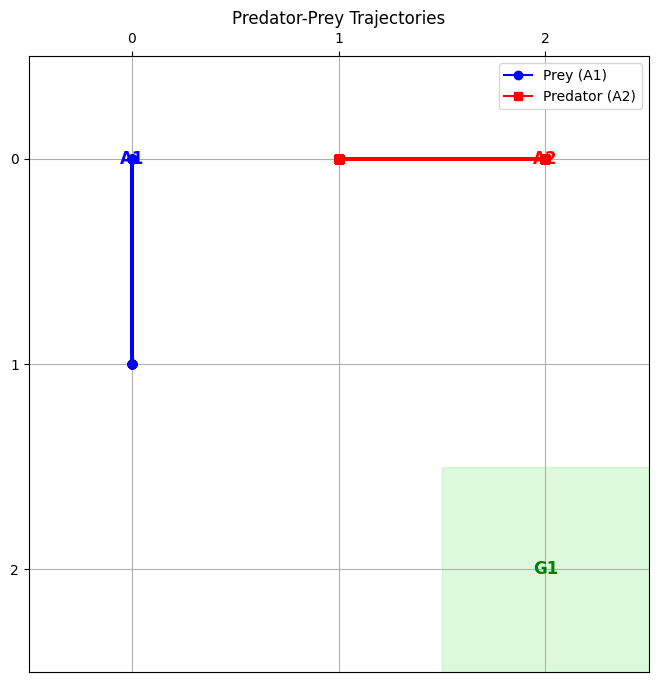

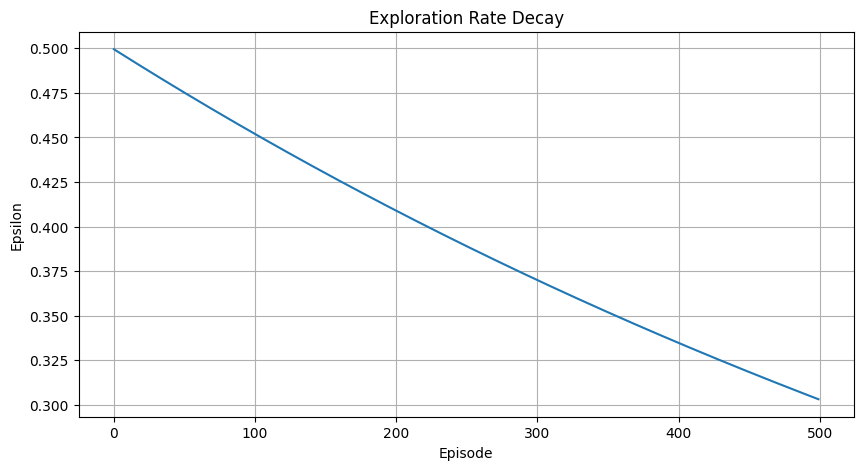

In [22]:
visualize_trajectory(agent, env)
plot_exploration_decay(epsilon_decay)